<a href="https://colab.research.google.com/github/moseskim/ml-at-work/blob/master/chap08/understanding_prediction_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![표지](https://raw.githubusercontent.com/moseskim/ml-at-work/master/images/cover.jpg)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

# 8장 머신러닝 모델 해석하기

## 구글 콜랩에 설치된 라이버리리 버전 업데이트

In [ ]:
!pip install -U -qq scikit-learn==0.24.1
!pip install -U -qq shap==0.39.0 dtreeviz==1.2

     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 356 kB 21.7 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 


In [ ]:
import sklearn
sklearn.__version__

'0.24.1'

## 학습용 파일 업로드

Kaggle에 로그인한 뒤 다음 CSV 파일을 다운로드한다

https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset?select=WA_Fn-UseC_-HR-Employee-Attrition.csv

다운로드한 파일은 Colloaboratory에 업로드한다.

In [ ]:
from google.colab import files
files.upload()

Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition.csv


{'WA_Fn-UseC_-HR-Employee-Attrition.csv': b'\xef\xbb\xbfAge,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager\r\n41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5\r\n49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7\r\n37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,

## 데이터 확인

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
source_df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
source_df.head(10)

Age Attrition  ... YearsSinceLastPromotion  YearsWithCurrManager
0   41       Yes  ...                       0                     5
1   49        No  ...                       1                     7
2   37       Yes  ...                       0                     0
3   33        No  ...                       3                     0
4   27        No  ...                       2                     2
5   32        No  ...                       3                     6
6   59        No  ...                       0                     0
7   30        No  ...                       0                     0
8   38        No  ...                       1                     8
9   36        No  ...                       7                     7

[10 rows x 35 columns]

In [ ]:
source_df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [ ]:
single_value_column = source_df.nunique() == 1
source_df.drop(source_df.columns[single_value_column], axis=1, inplace=True)

In [ ]:
attrition_label = (source_df.Attrition == 'Yes').astype(np.int64)
attrition_label

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

In [ ]:
categorical_df = source_df.select_dtypes(include=['object'])
categorical_df.drop(['Attrition'], axis=1, inplace=True)  # 목적 변수 제거
categorical_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


BusinessTravel              Department  ... MaritalStatus OverTime
0         Travel_Rarely                   Sales  ...        Single      Yes
1     Travel_Frequently  Research & Development  ...       Married       No
2         Travel_Rarely  Research & Development  ...        Single      Yes
3     Travel_Frequently  Research & Development  ...       Married      Yes
4         Travel_Rarely  Research & Development  ...       Married       No
...                 ...                     ...  ...           ...      ...
1465  Travel_Frequently  Research & Development  ...       Married       No
1466      Travel_Rarely  Research & Development  ...       Married       No
1467      Travel_Rarely  Research & Development  ...       Married      Yes
1468  Travel_Frequently                   Sales  ...       Married       No
1469      Travel_Rarely  Research & Development  ...       Married       No

[1470 rows x 7 columns]

In [ ]:
numerical_df = source_df.select_dtypes(include=['int64'])
numerical_df.drop(['EmployeeNumber'], axis=1, inplace=True)
numerical_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Age  DailyRate  ...  YearsSinceLastPromotion  YearsWithCurrManager
0      41       1102  ...                        0                     5
1      49        279  ...                        1                     7
2      37       1373  ...                        0                     0
3      33       1392  ...                        3                     0
4      27        591  ...                        2                     2
...   ...        ...  ...                      ...                   ...
1465   36        884  ...                        0                     3
1466   39        613  ...                        1                     7
1467   27        155  ...                        0                     3
1468   49       1023  ...                        0                     8
1469   34        628  ...                        1                     2

[1470 rows x 23 columns]

In [ ]:
converted_df = pd.concat([numerical_df, pd.get_dummies(categorical_df)], axis=1)
converted_df

Age  DailyRate  ...  OverTime_No  OverTime_Yes
0      41       1102  ...            0             1
1      49        279  ...            1             0
2      37       1373  ...            0             1
3      33       1392  ...            0             1
4      27        591  ...            1             0
...   ...        ...  ...          ...           ...
1465   36        884  ...            1             0
1466   39        613  ...            1             0
1467   27        155  ...            0             1
1468   49       1023  ...            1             0
1469   34        628  ...            1             0

[1470 rows x 51 columns]

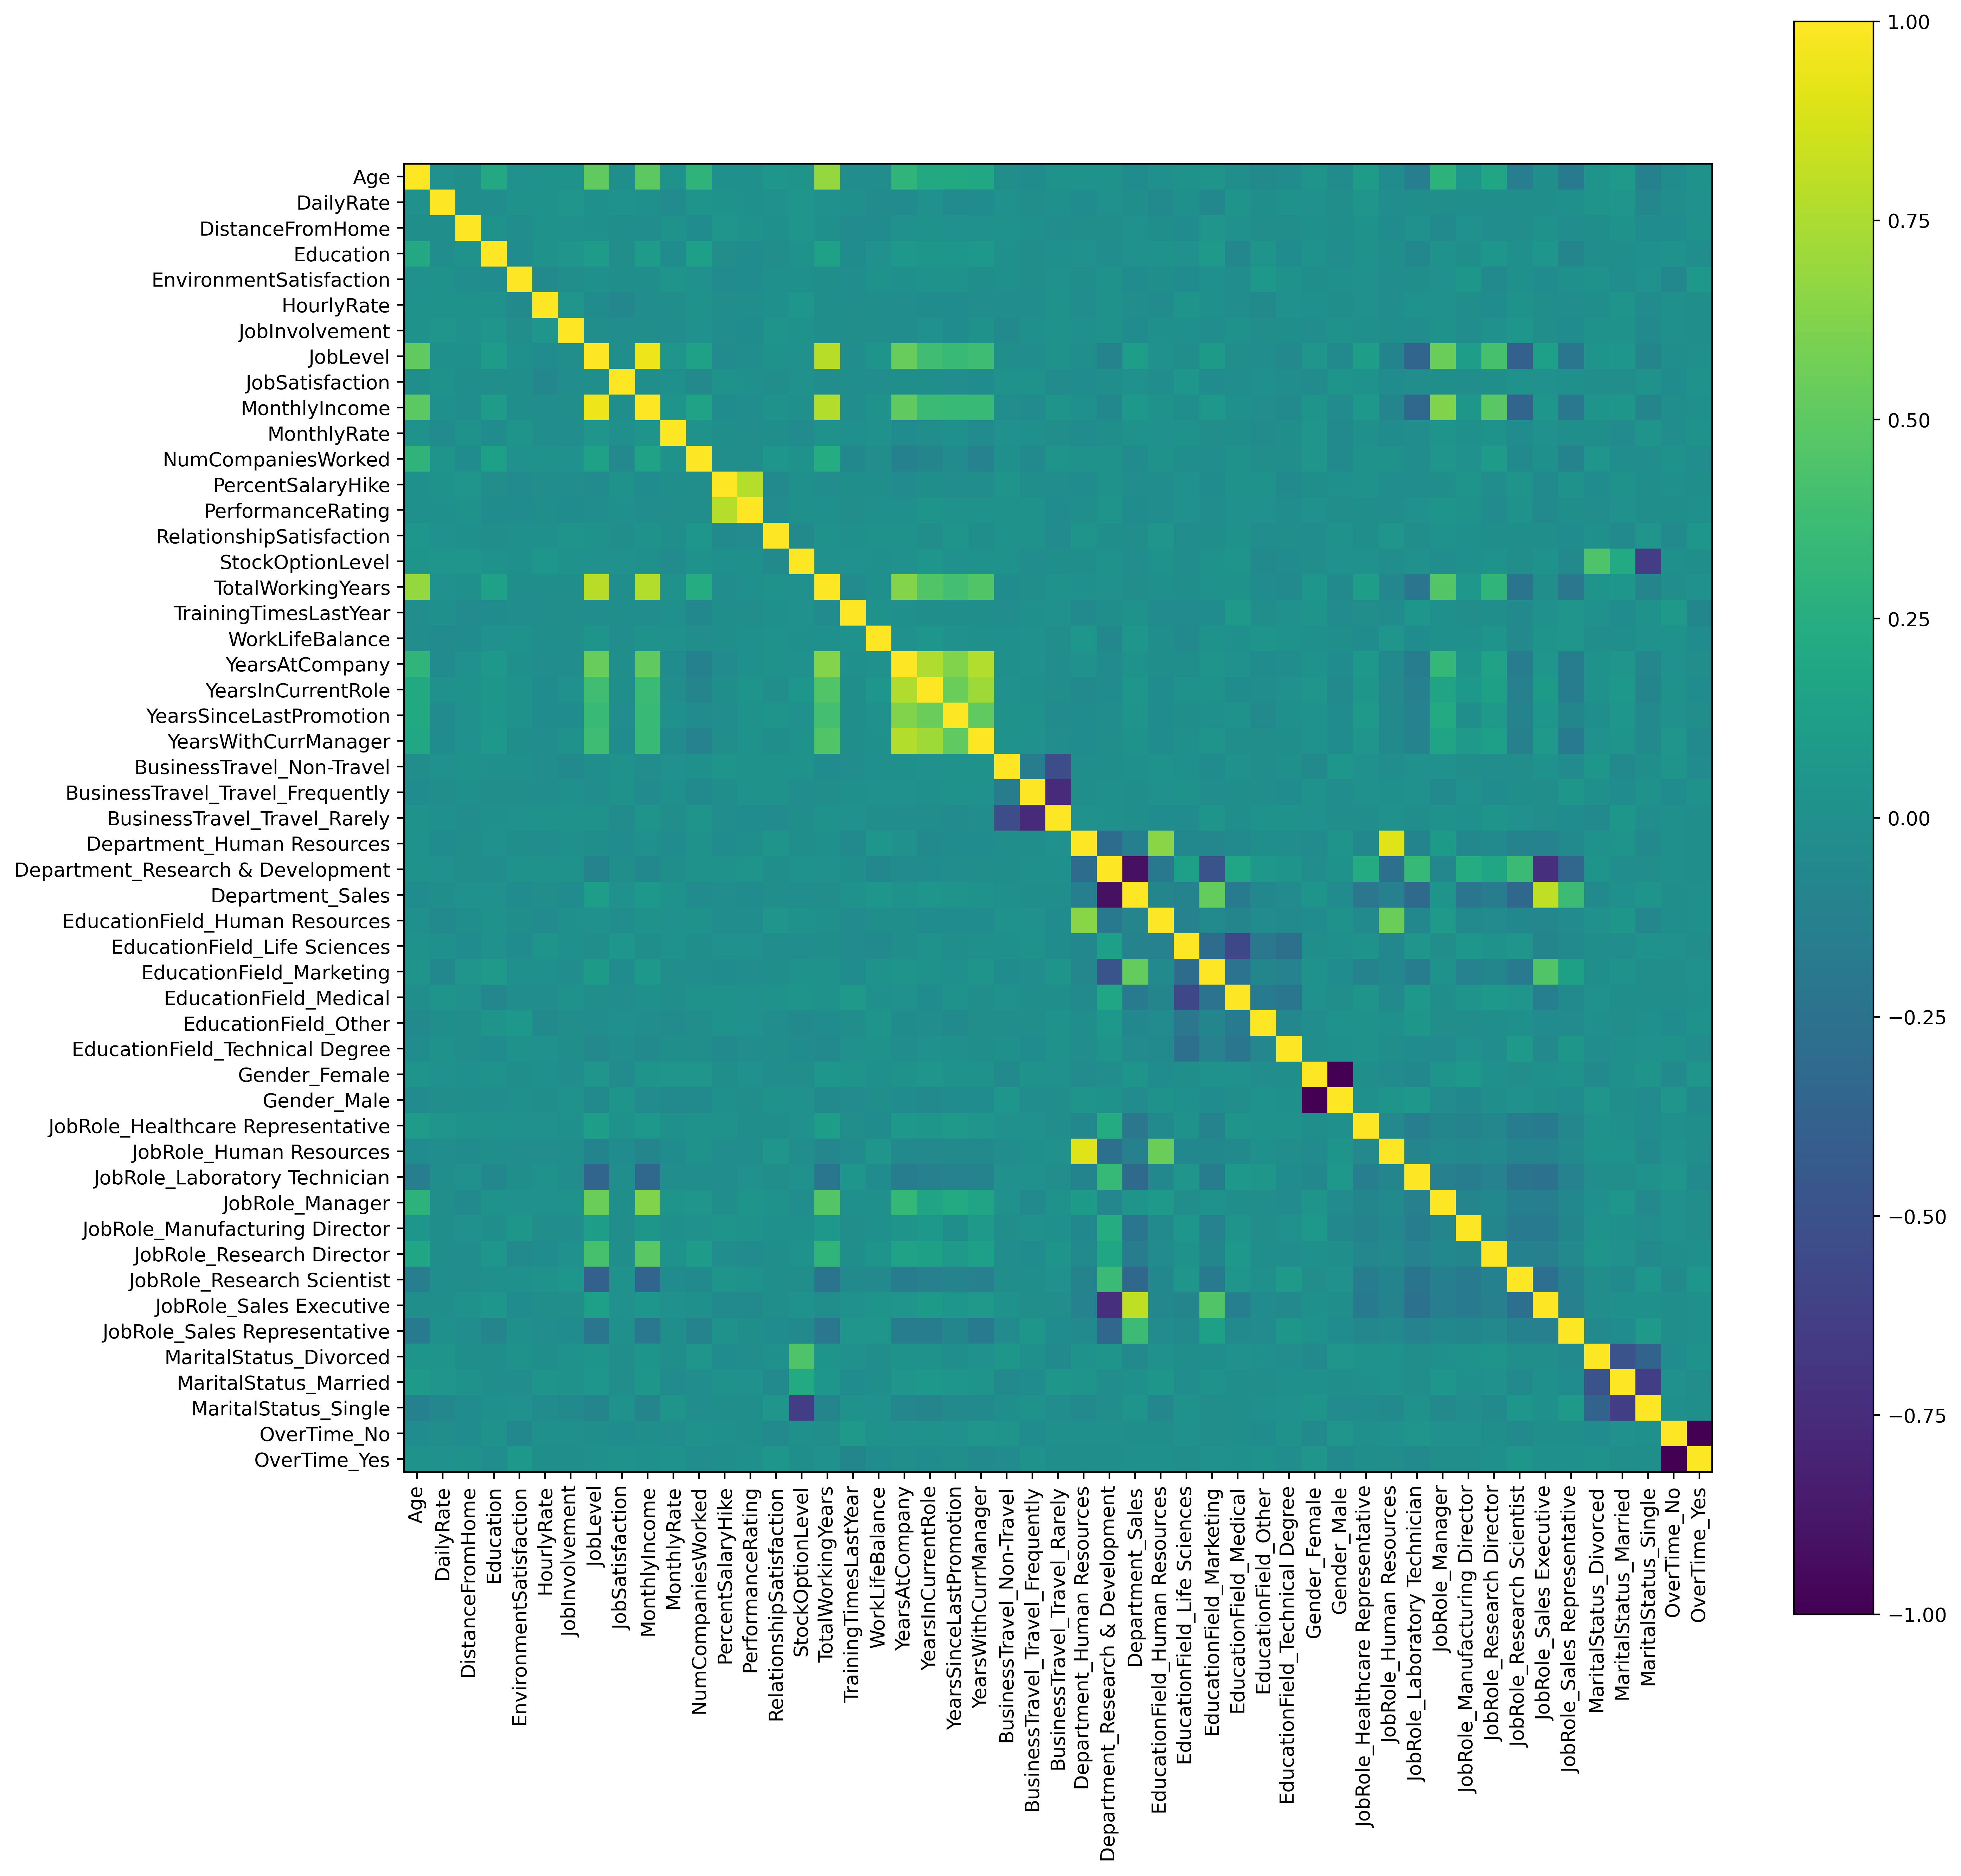

In [ ]:
plt.figure(figsize=(15, 15), dpi=400)
plt.imshow(converted_df.corr(), interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(converted_df.columns)), converted_df.columns, rotation='vertical')
plt.yticks(range(len(converted_df.columns)), converted_df.columns)
plt.show()

## 다중 회귀 분석 계수를 이용한 원인 해석


In [ ]:
import sklearn.linear_model
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(converted_df, attrition_label)

LinearRegression()

In [ ]:
linear_model_coef = list(zip(converted_df.columns, linear_model.coef_))
linear_model_coef.append(('intercept', linear_model.intercept_))
linear_model_coef

[('Age', -0.00349714081621159),
 ('DailyRate', -2.636998761938835e-05),
 ('DistanceFromHome', 0.003606848040478202),
 ('Education', 0.0017222192308999507),
 ('EnvironmentSatisfaction', -0.04050208861411766),
 ('HourlyRate', -0.00017550515338865148),
 ('JobInvolvement', -0.05798579466088014),
 ('JobLevel', -0.004882466209326685),
 ('JobSatisfaction', -0.037158450808713064),
 ('MonthlyIncome', 1.2948843340559755e-06),
 ('MonthlyRate', 4.5848746289743234e-07),
 ('NumCompaniesWorked', 0.01721237916905968),
 ('PercentSalaryHike', -0.002177532904306438),
 ('PerformanceRating', 0.018467358370601025),
 ('RelationshipSatisfaction', -0.023017447332442913),
 ('StockOptionLevel', -0.017022043769190604),
 ('TotalWorkingYears', -0.0037249552649408243),
 ('TrainingTimesLastYear', -0.013506928678868858),
 ('WorkLifeBalance', -0.031387116754425536),
 ('YearsAtCompany', 0.005492894264492279),
 ('YearsInCurrentRole', -0.009205359488122355),
 ('YearsSinceLastPromotion', 0.010821393431852925),
 ('YearsWith

In [ ]:
def check_coef(column_names, coef_list, intercept=None):
    weights = dict(zip(column_names, coef_list))
    if intercept:
      weights['intercept'] = intercept
    df = pd.DataFrame.from_dict(weights, orient='index')
    df.columns = ['coef']
    df.sort_values(by='coef', key=lambda t:abs(t), inplace=True, ascending=False)
    print(df.head(10))

In [ ]:
check_coef(converted_df.columns, linear_model.coef_, linear_model.intercept_)

                                       coef
intercept                          0.874182
JobRole_Sales Representative       0.164880
JobRole_Human Resources            0.124988
OverTime_Yes                       0.105340
OverTime_No                       -0.105340
JobRole_Research Director         -0.092631
JobRole_Healthcare Representative -0.090496
EducationField_Human Resources     0.085261
BusinessTravel_Travel_Frequently   0.079816
Department_Human Resources        -0.078630


In [ ]:
import sklearn.preprocessing 
scaler = sklearn.preprocessing.MinMaxScaler()
standardization_df = pd.DataFrame(scaler.fit_transform(converted_df),
                                  index=converted_df.index,
                                  columns=converted_df.columns)
standardization_df

Age  DailyRate  ...  OverTime_No  OverTime_Yes
0     0.547619   0.715820  ...          0.0           1.0
1     0.738095   0.126700  ...          1.0           0.0
2     0.452381   0.909807  ...          0.0           1.0
3     0.357143   0.923407  ...          0.0           1.0
4     0.214286   0.350036  ...          1.0           0.0
...        ...        ...  ...          ...           ...
1465  0.428571   0.559771  ...          1.0           0.0
1466  0.500000   0.365784  ...          1.0           0.0
1467  0.214286   0.037938  ...          0.0           1.0
1468  0.738095   0.659270  ...          1.0           0.0
1469  0.380952   0.376521  ...          1.0           0.0

[1470 rows x 51 columns]

In [ ]:
import sklearn.linear_model
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(standardization_df, attrition_label)
check_coef(converted_df.columns, linear_model.coef_, linear_model.intercept_)

                                           coef
intercept                          6.031548e+13
Department_Human Resources        -1.729127e+13
Department_Sales                  -1.729127e+13
Department_Research & Development -1.729127e+13
JobRole_Healthcare Representative -1.475151e+13
JobRole_Research Director         -1.475151e+13
JobRole_Manufacturing Director    -1.475151e+13
JobRole_Research Scientist        -1.475151e+13
JobRole_Manager                   -1.475151e+13
JobRole_Sales Executive           -1.475151e+13


In [ ]:
converted_dropped_df = pd.concat([numerical_df, pd.get_dummies(categorical_df, drop_first=True)], axis=1)
scaler = sklearn.preprocessing.MinMaxScaler()
standardization_dropped_df = pd.DataFrame(scaler.fit_transform(converted_dropped_df),
                                  index=converted_dropped_df.index,
                                  columns=converted_dropped_df.columns)
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(standardization_dropped_df, attrition_label)
check_coef(standardization_dropped_df.columns, linear_model.coef_, linear_model.intercept_)

                                  coef
intercept                     0.327084
JobRole_Sales Representative  0.255376
YearsAtCompany                0.219716
JobRole_Human Resources       0.215485
OverTime_Yes                  0.210679
JobInvolvement               -0.173957
YearsInCurrentRole           -0.165696
YearsWithCurrManager         -0.162449
YearsSinceLastPromotion       0.162321
NumCompaniesWorked            0.154911


## 로지스틱 회귀 계수를 이용한 원인 확인 해석


In [ ]:
lr_model = sklearn.linear_model.LogisticRegression(C=0.1)
lr_model.fit(standardization_dropped_df, attrition_label)
check_coef(standardization_dropped_df.columns, lr_model.coef_[0], lr_model.intercept_[0])

                                      coef
OverTime_Yes                      1.259661
JobInvolvement                   -0.719254
EnvironmentSatisfaction          -0.673118
JobSatisfaction                  -0.660775
BusinessTravel_Travel_Frequently  0.651580
MaritalStatus_Single              0.633452
JobRole_Laboratory Technician     0.566878
NumCompaniesWorked                0.564474
DistanceFromHome                  0.527556
Age                              -0.524708


In [ ]:
lr_model = sklearn.linear_model.LogisticRegression(C=10000)
lr_model.fit(standardization_dropped_df, attrition_label)
check_coef(standardization_dropped_df.columns, lr_model.coef_[0], lr_model.intercept_[0])

                                       coef
JobRole_Human Resources            4.784336
intercept                         -3.815189
YearsAtCompany                     3.670243
Department_Research & Development  3.488477
Department_Sales                   3.190644
YearsInCurrentRole                -2.646768
YearsSinceLastPromotion            2.579940
TotalWorkingYears                 -2.452995
JobRole_Sales Representative       2.307810
YearsWithCurrManager              -2.243526


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
lr_model.classes_

array([0, 1])

## 회귀 계수의 P값 구하기


In [ ]:
import statsmodels.api
ols_df = standardization_dropped_df.copy()
ols_df['const'] = 1
ols_model = statsmodels.api.OLS(attrition_label, ols_df)
fit_ols_results = ols_model.fit()
fit_ols_summary = fit_ols_results.summary2()
print(fit_ols_summary)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                         Results: Ordinary least squares
Model:                   OLS                   Adj. R-squared:          0.235    
Dependent Variable:      Attrition             AIC:                     882.5729 
Date:                    2021-07-17 21:57      BIC:                     1120.7587
No. Observations:        1470                  Log-Likelihood:          -396.29  
Df Model:                44                    F-statistic:             11.24    
Df Residuals:            1425                  Prob (F-statistic):      6.55e-65 
R-squared:               0.258                 Scale:                   0.10356  
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------
Age                               -0.1469   0.0557 -2.6363 0.0085 -0.2562 -0.0376
DailyRate                         -0.0368

In [ ]:
sorted_ols_coef = fit_ols_summary.tables[1].sort_values(by='Coef.', key=lambda t:abs(t), ascending=False)
sorted_ols_coef = sorted_ols_coef[sorted_ols_coef['P>|t|'] < 0.05]
sorted_ols_coef[:10]

Coef.  Std.Err.  ...    [0.025    0.975]
const                             0.327084  0.138981  ...  0.054455  0.599714
JobRole_Sales Representative      0.255376  0.086063  ...  0.086552  0.424200
OverTime_Yes                      0.210679  0.018954  ...  0.173498  0.247860
JobInvolvement                   -0.173957  0.035970  ... -0.244517 -0.103398
YearsInCurrentRole               -0.165696  0.069743  ... -0.302507 -0.028886
YearsWithCurrManager             -0.162449  0.067498  ... -0.294855 -0.030043
YearsSinceLastPromotion           0.162321  0.051224  ...  0.061839  0.262803
NumCompaniesWorked                0.154911  0.034255  ...  0.087716  0.222107
BusinessTravel_Travel_Frequently  0.152732  0.033034  ...  0.087931  0.217533
Age                              -0.146880  0.055715  ... -0.256172 -0.037588

[10 rows x 6 columns]

## 결정 트리를 시각화해 원인 해석


[Text(7750.0, 2642.5, 'OverTime_No <= 0.5\ngini = 0.27\nsamples = 1470\nvalue = [1233, 237]'),
 Text(3875.0, 1887.5, 'MonthlyIncome <= 2475.0\ngini = 0.424\nsamples = 416\nvalue = [289, 127]'),
 Text(1937.5, 1132.5, 'DailyRate <= 931.0\ngini = 0.423\nsamples = 69\nvalue = [21, 48]'),
 Text(968.75, 377.5, 'gini = 0.214\nsamples = 41\nvalue = [5, 36]'),
 Text(2906.25, 377.5, 'gini = 0.49\nsamples = 28\nvalue = [16, 12]'),
 Text(5812.5, 1132.5, 'MaritalStatus_Single <= 0.5\ngini = 0.352\nsamples = 347\nvalue = [268, 79]'),
 Text(4843.75, 377.5, 'gini = 0.261\nsamples = 246\nvalue = [208, 38]'),
 Text(6781.25, 377.5, 'gini = 0.482\nsamples = 101\nvalue = [60, 41]'),
 Text(11625.0, 1887.5, 'TotalWorkingYears <= 2.5\ngini = 0.187\nsamples = 1054\nvalue = [944, 110]'),
 Text(9687.5, 1132.5, 'JobRole_Research Scientist <= 0.5\ngini = 0.442\nsamples = 88\nvalue = [59, 29]'),
 Text(8718.75, 377.5, 'gini = 0.495\nsamples = 60\nvalue = [33, 27]'),
 Text(10656.25, 377.5, 'gini = 0.133\nsamples = 28

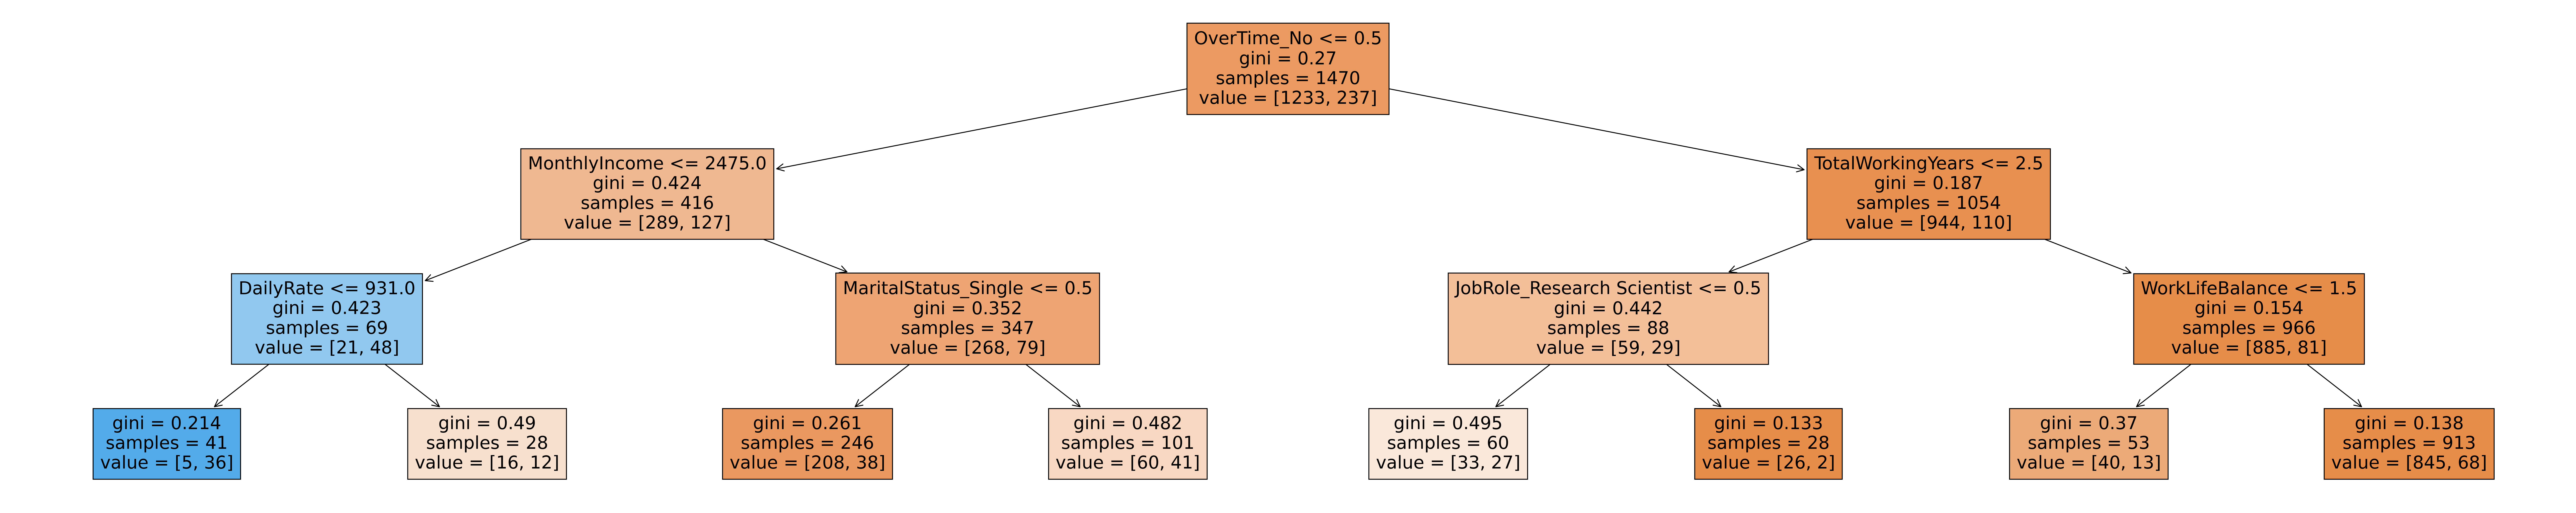

In [ ]:
import sklearn.tree
dt_model = sklearn.tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(converted_df, attrition_label)

plt.figure(figsize=(50, 10), dpi=400)
sklearn.tree.plot_tree(dt_model, feature_names=converted_df.columns ,filled=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


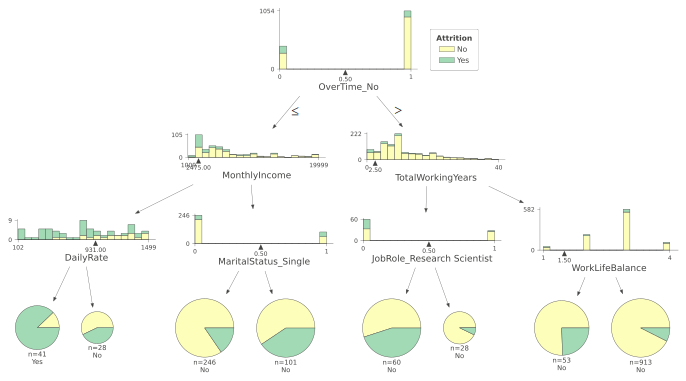

In [ ]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(dt_model,
              converted_df,
              attrition_label,
              target_name='Attrition',
              feature_names=converted_df.columns,
              class_names=['No', 'Yes'])              
viz

## 랜덤 포레스트의 feature importance 시각화


In [ ]:
import sklearn.ensemble
rf_model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=100,
    max_depth=5,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(converted_df, attrition_label)
check_coef(converted_df.columns, rf_model.feature_importances_)

                          coef
MonthlyIncome         0.119744
OverTime_Yes          0.118544
OverTime_No           0.107013
JobLevel              0.087204
TotalWorkingYears     0.086532
YearsAtCompany        0.077841
StockOptionLevel      0.072223
YearsWithCurrManager  0.056186
Age                   0.050884
MaritalStatus_Single  0.033496


In [ ]:
duplicated_df = converted_df.copy()
for i in range(10):
  duplicated_df['MonthlyIncome{}'.format(i)] =duplicated_df.MonthlyIncome

rf_model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=100,
    max_depth=5,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(duplicated_df, attrition_label)
check_coef(duplicated_df.columns, rf_model.feature_importances_)

                       coef
OverTime_Yes       0.068042
MonthlyIncome8     0.067456
OverTime_No        0.063503
MonthlyIncome9     0.052984
MonthlyIncome6     0.051916
TotalWorkingYears  0.050806
MonthlyIncome3     0.048600
StockOptionLevel   0.048092
MonthlyIncome2     0.045324
MonthlyIncome1     0.042143


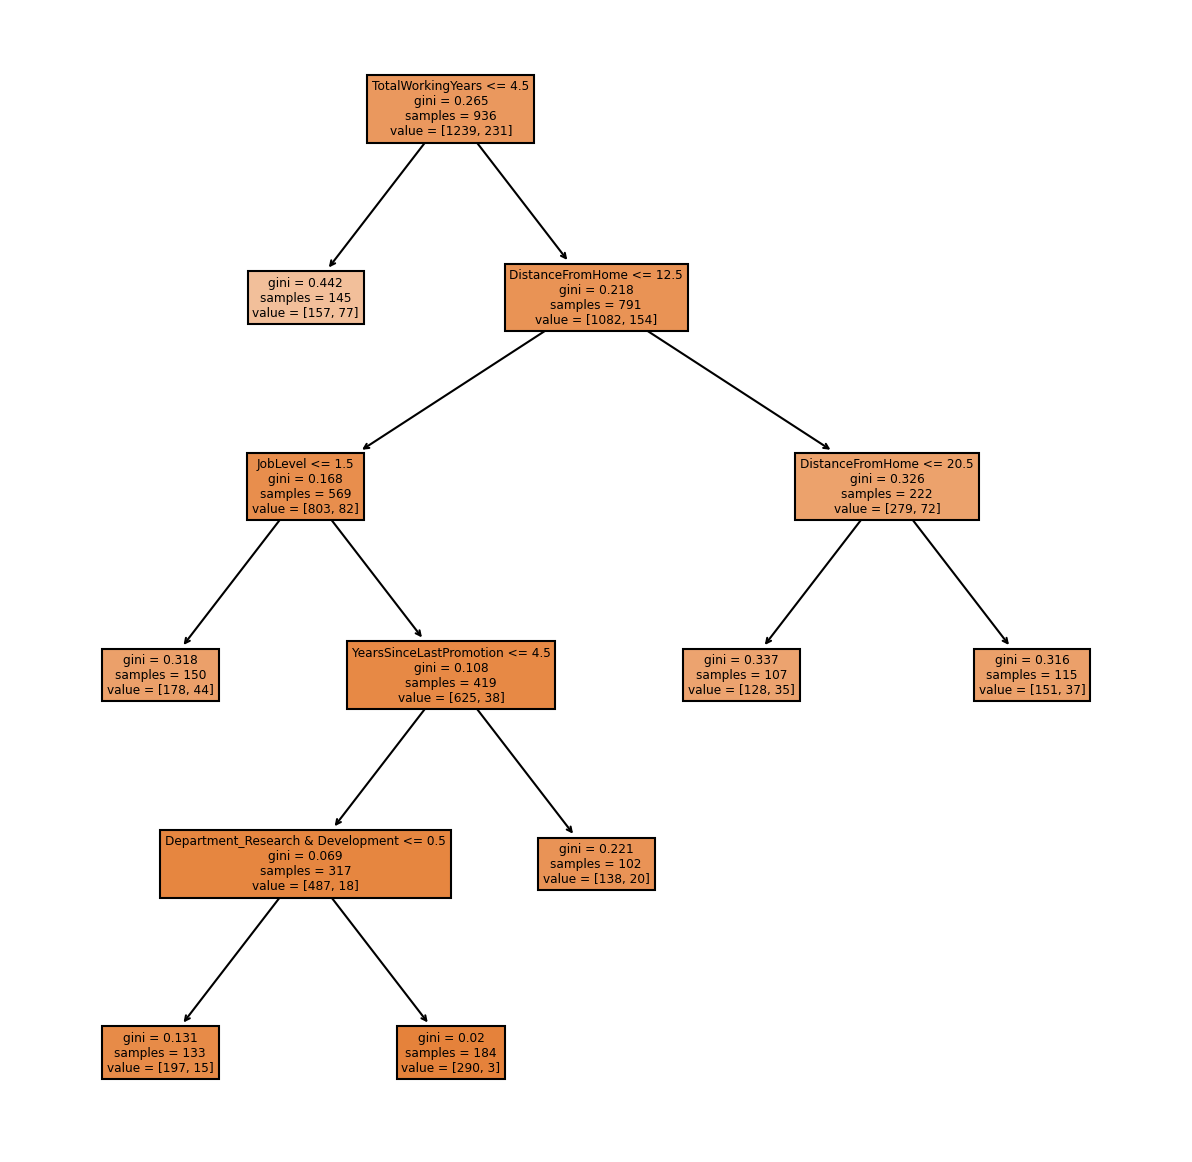

In [ ]:
rf_model.fit(converted_df, attrition_label)
plt.figure(figsize=(10, 10), dpi=150)
sklearn.tree.plot_tree(rf_model.estimators_[0], feature_names=converted_df.columns ,filled=True)
plt.show()

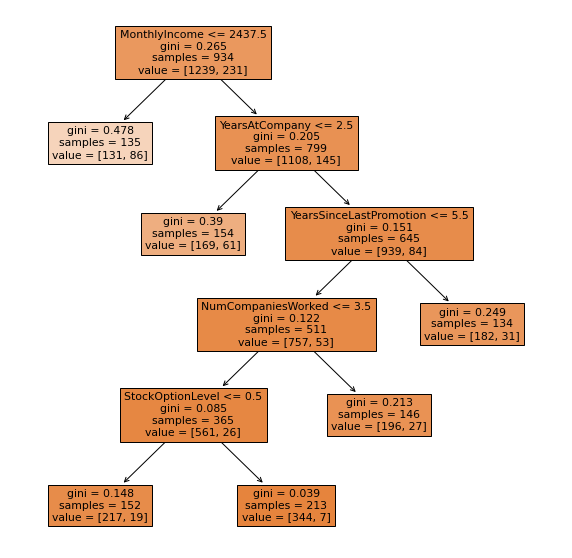

In [ ]:
plt.figure(figsize=(10, 10))
sklearn.tree.plot_tree(rf_model.estimators_[1], feature_names=converted_df.columns ,filled=True)
plt.show()

## SHAP를 이용한 기여도 시각화


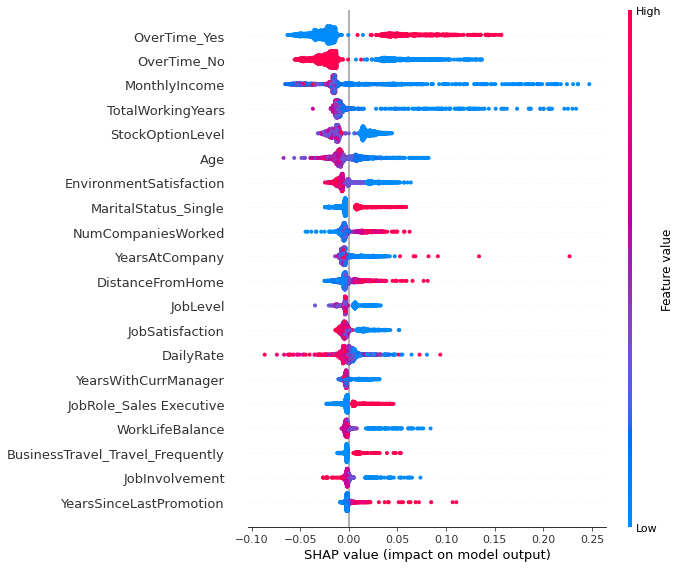

In [ ]:
import shap
rf_model = sklearn.ensemble.RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(converted_df, attrition_label)

shap.initjs()
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(converted_df)

plt.figure()
shap.summary_plot(shap_values, converted_df, show=False)


## SHAP를 이용한 직원 만족도 시각화

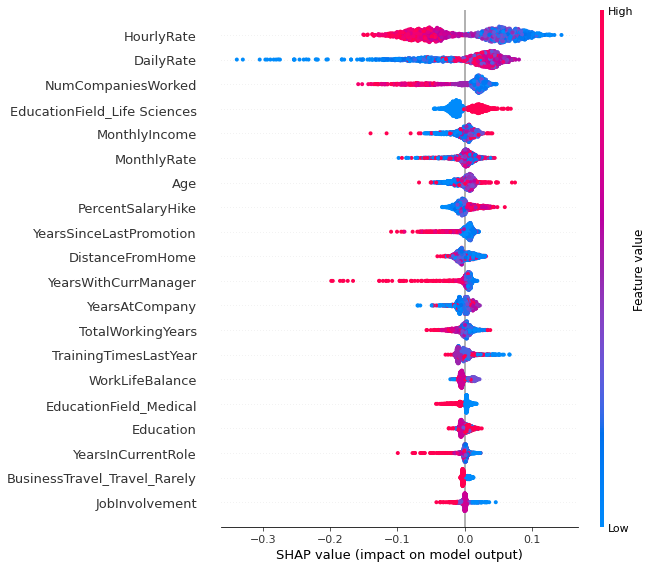

In [ ]:
target_label = "JobSatisfaction"
X = converted_df.drop([target_label], axis=1)
Y = converted_df[target_label] 

rf_model = sklearn.ensemble.RandomForestRegressor(
    n_estimators=300,

    max_depth=5,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X, Y)

shap.initjs()
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

plt.figure()
shap.summary_plot(shap_values, X, show=False)